# Week 4: Geospatial Data Analysis, Continued

- Thursday September 26 and Thursday October 10

**Recently we discussed**
- Vector data and introduction to GeoPandas
- Spatial relationships
- Spatial joins

**Now we go into...**

- Visualization for geospatial data
- Demo: 311 requests by neighborhood in Philadelphia
- Folium(Leaflet) - interactive

In [32]:
# Let's setup the imports we'll need first
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Example: Exploring trash-related 311 tickets by neighborhood in 2020

Let's continuing analyzing data for 311 requests in Philadelphia during the pandemic in 2020. Today, we'll dive into examining trends by neighborhood.

Trash collection was a big concern in Philadelphia when the pandemic began.
Check out [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer for more details!


First, let's load our data and create our GeoDataFrame. 

**Note:** The below code is copied over from last lecture.

In [33]:
# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "data/trash_311_requests_2020.csv"  # Use the file path relative to the current folder
)

# Remove rows with missing geometry
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])

# Create our GeoDataFrame with geometry column created from lon/lat
trash_requests = gpd.GeoDataFrame(
    trash_requests_df,
    geometry=gpd.points_from_xy(trash_requests_df["lon"], trash_requests_df["lat"]),
    crs="EPSG:4326",
)

Now let's examine the trends by neighborhoods across the city.

**Goal:** For each neighborhood, calculate the number of trash-related requests

### 1. Load Zillow neighborhood data

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

In [34]:
zillow = gpd.read_file("data/zillow_neighborhoods.geojson")

In [35]:
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-74.99851 40.06435, -74.99456 40.061...
1           Airport  POLYGON ((-75.19728 39.89252, -75.19617 39.892...
2    Allegheny West  POLYGON ((-75.16592 40.00327, -75.16596 40.003...
3           Andorra  POLYGON ((-75.22463 40.06686, -75.22588 40.065...
4  Aston Woodbridge  POLYGON ((-75.00860 40.05369, -75.00861 40.053...

Convert to a better CRS (EPSG:3857) and make a quick plot:

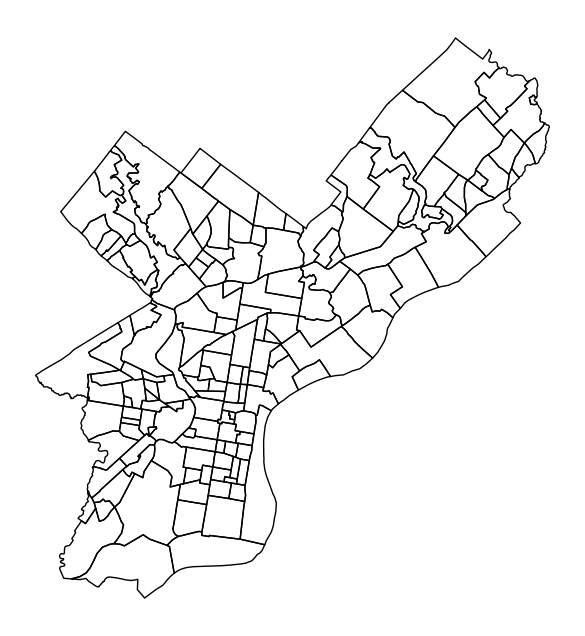

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = zillow.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

### 2. Do a spatial join between requests and neighborhoods

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods) based on which neighborhood each request location is within.


::: {.callout-important}
Make sure the two GeoDataFrames are in the same CRS when calculating a spatial join! If not, geopandas will print out a warning.
:::

In [37]:
requests_with_hood = gpd.sjoin(
    trash_requests,  # The point data for 311 tickets
    zillow.to_crs(trash_requests.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)

In [38]:
requests_with_hood.head()

objectid  service_request_id  status  status_notes  \
0   8180042            13269656  Closed           NaN   
1   8180043            13266979  Closed           NaN   
2   7744426            13066443  Closed           NaN   
3   7744427            13066540  Closed           NaN   
4   7801094            13089345  Closed           NaN   

                             service_name service_code  agency_responsible  \
0  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
1  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
2  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
3  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
4  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

    service_notice   requested_datetime     updated_datetime  \
0  2 Business Days  2020-04-02 19:22:24  2020-04-06 07:02:57   
1  2 Business Days  2020-04-02 08:40:53  2020-04-06 07:02:58   
2  2 Business Days  2020-01-02 19:17:55  2020-01-04 05:46:06   
3  2 Business Days  2020-01-03 07:01:46  2020-01-04 05:46:07   
4  2 Business Days  2020-01-15 13:22:14  2020-01-16 14:03:29   

     expected_datetime            address zipcode media_url        lat  \
0  2020-04-06 20:00:00    624 FOULKROD ST     NaN       NaN  40.034389   
1  2020-04-05 20:00:00  1203 ELLSWORTH ST     NaN       NaN  39.936164   
2  2020-01-06 19:00:00   9054 WESLEYAN RD     NaN       NaN  40.058737   
3  2020-01-06 19:00:00    2784 WILLITS RD     NaN       NaN  40.063658   
4  2020-01-16 19:00:00     6137 LOCUST ST     NaN       NaN  39.958186   

         lon                    geometry  index_right       ZillowName  
0 -75.106518  POINT (-75.10652 40.03439)         70.0         Lawndale  
1 -75.163497  POINT (-75.16350 39.93616)        105.0  Passyunk Square  
2 -75.018345  POINT (-75.01835 40.05874)        109.0  Pennypack Woods  
3 -75.022347  POINT (-75.02235 40.06366)        107.0        Pennypack  
4 -75.244732  POINT (-75.24473 39.95819)         21.0      Cobbs Creek

### 3. Group by neighborhood and calculate the size

In [39]:
totals = requests_with_hood.groupby("ZillowName", as_index=False).size()

type(totals)

pandas.core.frame.DataFrame

**Note:** we're once again using the `as_index=False` to ensure the result of the `.size()` function is a DataFrame rather than a Series with the `ZillowName` as its index

In [40]:
totals.head()

ZillowName  size
0   Academy Gardens    84
1    Allegheny West   330
2           Andorra    83
3  Aston Woodbridge   110
4   Bartram Village    35

### 4. Merge our geometries back in

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of requests per neighborhood (DataFrame).

::: {.callout-important}

When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

:::

For example...

In [41]:
# Do GeoDataFrame.merge(DataFrame) here...
requests_by_hood = zillow.merge(totals, on="ZillowName")

In [42]:
requests_by_hood.head()

ZillowName                                           geometry  size
0   Academy Gardens  POLYGON ((-74.99851 40.06435, -74.99456 40.061...    84
1    Allegheny West  POLYGON ((-75.16592 40.00327, -75.16596 40.003...   330
2           Andorra  POLYGON ((-75.22463 40.06686, -75.22588 40.065...    83
3  Aston Woodbridge  POLYGON ((-75.00860 40.05369, -75.00861 40.053...   110
4   Bartram Village  POLYGON ((-75.20733 39.93350, -75.20733 39.933...    35

We'll do some plotting below, so let's convert to a more accurate CRS and save a new version:

In [43]:
requests_by_hood_3857 = requests_by_hood.to_crs(epsg=3857)

## Data viz example: Choropleth maps

Choropleth maps color polygon regions according to the values of a specific data attribute. In this section, we'll explore a number of different ways to plot them in Python.

### Static via the geopandas `plot()` function

Choropleth maps are *built-in* to GeoDataFrame objects via the `plot()` function. Let's use the "size" column to plot the total number of requests per neighborhood:

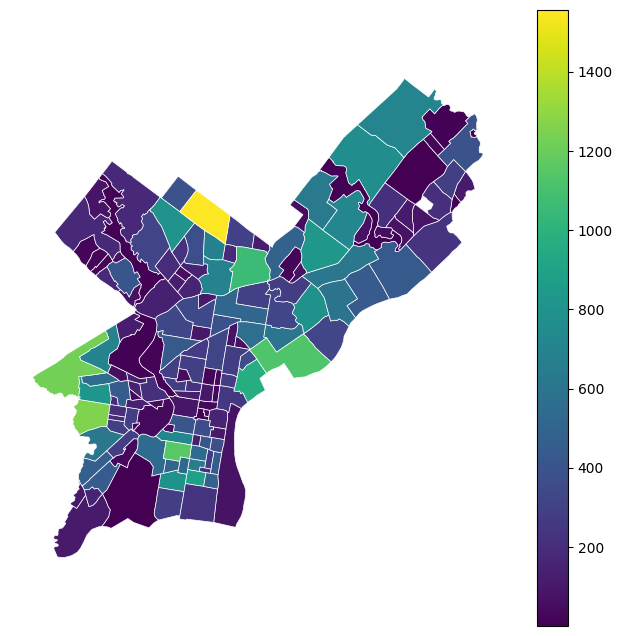

In [44]:
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="size",  # NEW: Specify the column to color polygons by
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

#### 1. Improving the aesthetics

Two optional but helpful improvements:
- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [45]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

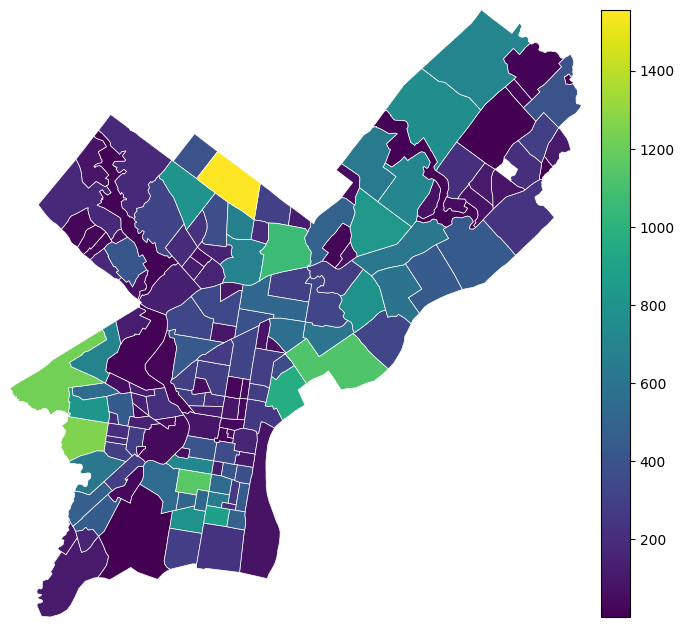

In [46]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    cax=cax,  # NEW
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood_3857.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

*These improvements are optional, but they definitely make for nicer plots!*

#### 2. Improving the data

**Problem:** The variation in the sizes of neighborhoods across the city makes it hard to compare raw counts in a choropleth map.

Better to normalize by area: **use the .area attribute of the geometry series**

In [47]:
requests_by_hood_3857["N_per_area"] = (
    requests_by_hood_3857["size"] / (requests_by_hood_3857.geometry.area) * 1e4
)

Now plot the normalized totals:

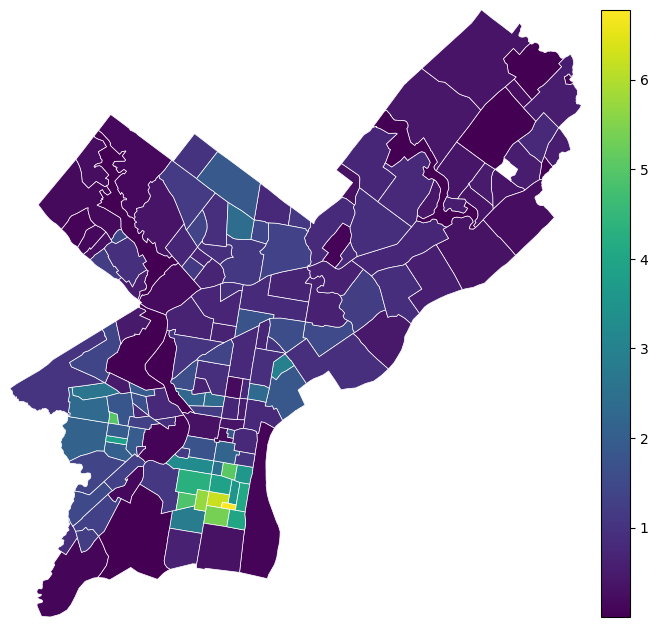

In [48]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    cax=cax,
    column="N_per_area",  # NEW: Use the normalized column
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood_3857.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

**Even better...**

Since households are driving the 311 requests, it would be even better to normalize by the number of properties in a given neighborhood rather than neighborhood area.

#### 3. Improving the color mapping


By default, geopandas just maps the data to a continuous color bar. Sometimes, it is helpful to instead classify the data into bins and visualize the separate bins. This can help highlight trends not immediately clear when using a continuous color mapping. 

Classification via bins is built-in to the `plot()` function! Many different schemes, but here are some of the most common ones:

1. **Quantiles:** assigns the same number of data points per bin
1. **EqualInterval:** divides the *range of the data* into equally sized bins
1. **FisherJenks:** [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.

Trying out multiple classification schemes can help you figure out trends more easily during your exploratory analysis!

1. **Quantiles Scheme:** assigns the same number of data points per bin

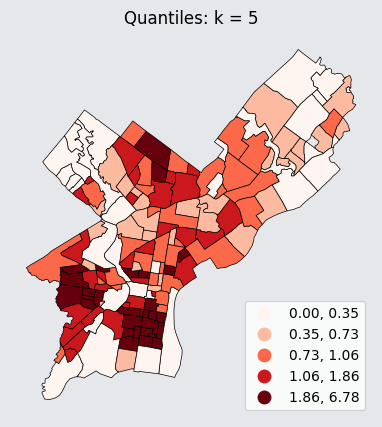

In [49]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="N_per_area",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="Quantiles", # NEW
    k=5, # NEW
)

# Format
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

2. **Equal Interval Scheme:** divides the *range of the data* into equally sized bins

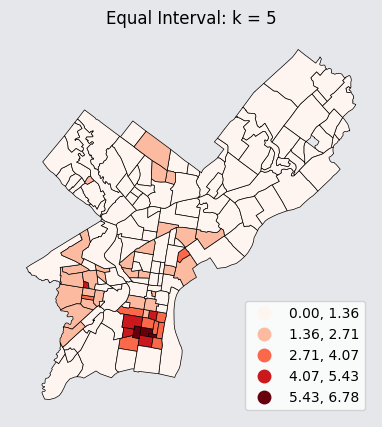

In [50]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="N_per_area",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="EqualInterval",
    k=5,
)

# Format
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

3. **Fisher Jenks Scheme**: minimize the variance within each bin and maximize the variances between different bins.

/Users/delmelle/miniforge3/lib/python3.10/site-packages/geopandas/plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


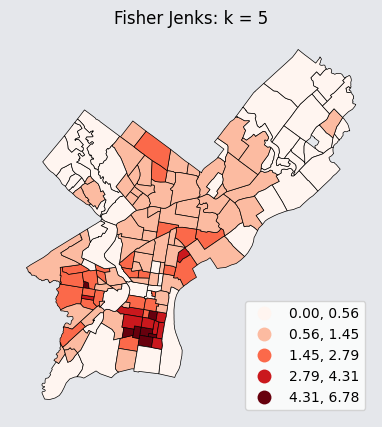

In [51]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood_3857.plot(
    ax=ax,
    column="N_per_area",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="FisherJenks",
)

# Format
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

::: {.callout-tip}

Geopandas relies on an external package called `mapclassify` for the classification schemes. 
The documentation can be found here: https://pysal.org/mapclassify/api.html

It contains the full list of schemes and the function definitions for each.
:::

### Interactive via altair

Altair charts accept `GeoDataFrames` as data and altair includes a "geoshape" mark, so choropleths are easy to make.


::: {.callout-important title="Altair and projections"}

Altair's support for different projections isn't the best. The recommended strategy is to convert your data to the desired CRS (e.g., EPSG:3857 or the local state plane projection (EPSG:2272 for Philadelphia)) and then tell altair not to project your data by including the following:

```python
chart.project(type="identity", reflectY=True)
```

:::

In [52]:
(
    alt.Chart(requests_by_hood_3857)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["N_per_area:Q", "ZillowName:N", "size:Q"],
        color=alt.Color("N_per_area:Q", scale=alt.Scale(scheme="viridis")),
    )
    # Important! Otherwise altair will try to re-project your data
    .project(type="identity", reflectY=True)
    .properties(width=500, height=500)
)

alt.Chart(...)

### Interactive via hvplot

We can use the built-in `.hvplot()` function to plot interactive choropleth maps!


::: {.callout-important title="Hvplot and projections"}

There are two relevant keywords related to projections and coordinate reference systems. Since we are plotting geospatial data, you will need to specify the `geo=True` keyword. If your data is in EPSG:4326, you are all set and that's all you need to do. If your data is NOT in EPSG:4326, you will need to specify the `crs=` keyword and pass the EPSG code to hvplot. 

In the example below, our data is in EPSG:3857 and we specify that via the `crs` keyword.


:::

In [53]:
requests_by_hood_3857.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
!pip install cartopy geoviews

  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/03/3a/724864cbce89a15cbb8476387510c1ab0fcbd38b689f881e775ae32d7178/Cartopy-0.23.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for geoviews from https://files.pythonhosted.org/packages/fe/c1/11add578ab3a2f3d9210d651a2c7ccb4a8cfec3e9cc2f4a00cbcd58af699/geoviews-1.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for bokeh<3.6.0,>=3.5.0 from https://files.pythonhosted.org/packages/75/47/c3971a7a011c8d80a0c7e40c7f51e6a6bb2a186b46a5ec2d2ade49d6b970/bokeh-3.5.2-py3-none-any.whl.metadata
  Using cached bokeh-3.5.2-py3-none-any.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of panel to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for panel>=1.0.0 from https://files.pythonhosted.org/packages/0f/74/034c07d7bcbae146d12b12371a1b20e885b6fcf2929201e45acbe6d99063/pane

In [56]:
# Pass arguments directly to hvplot()
# and it recognizes polygons automatically
requests_by_hood_3857.hvplot(
    c="N_per_area",
    frame_width=600,
    frame_height=600,
    geo=True,
    crs=3857,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

:Polygons   [Longitude,Latitude]   (N_per_area,ZillowName)

#### Adding in tile maps underneath with geoviews

hvplot can leverage the power of [geoviews](https://geoviews.org/index.html), the geographic equivalent of holoviews, to add in base tile maps underneath our choropleth map.

Let's try it out:

In [57]:
import geoviews as gv
import geoviews.tile_sources as gvts

In [58]:
type(gvts.EsriImagery)

geoviews.element.geo.WMTS

In [59]:
%%opts WMTS [width=800, height=800, xaxis=None, yaxis=None]

choro = requests_by_hood_3857.hvplot(
    c="N_per_area",
    frame_width=600,
    frame_height=600,
    alpha=0.5,
    geo=True,
    crs=3857,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

gvts.EsriImagery * choro

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (N_per_area,ZillowName)

::: {.callout-warning}

For the moment, you'll need to have your overlaid polygons in Web Mercator, EPSG:3857. There's a bug in geoviews that is preventing the underlying raster data from showing properly when combined with data that is using a different CRS.

:::

#### Many of the most common tile sources are available..

*Stay tuned:* More on this next week when we talk about raster data!

In [60]:
%%opts WMTS [width=200, height=200, xaxis=None, yaxis=None]

(
    gvts.OSM
    + gvts.StamenToner
    + gvts.EsriNatGeo
    + gvts.EsriImagery
    + gvts.EsriUSATopo
    + gvts.EsriTerrain
    + gvts.CartoDark
    + gvts.CartoLight
).cols(4)

:Layout
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .WMTS.II   :WMTS   [Longitude,Latitude]
   .WMTS.III  :WMTS   [Longitude,Latitude]
   .WMTS.IV   :WMTS   [Longitude,Latitude]
   .WMTS.V    :WMTS   [Longitude,Latitude]
   .WMTS.VI   :WMTS   [Longitude,Latitude]
   .WMTS.VII  :WMTS   [Longitude,Latitude]
   .WMTS.VIII :WMTS   [Longitude,Latitude]

::: {.callout-note}

We've used the `%%opts` cell magic to apply syling options to any charts generated in the cell.

See [the documentation guide on customizations](http://holoviews.org/user_guide/Notebook_Magics.html) for more details.

:::

### Interactive via the geopandas `.explore()` function

Geopandas recently introduced the ability to produce interactive choropleth maps via the `.explore()` function. It leverages the [Folium](https://python-visualization.github.io/folium/latest/) package to produce an interactive web map. 

**Stay tuned:** We'll discuss interactive web maps and the Folium package in much more detail next week!

In [61]:
requests_by_hood_3857.explore(
    column="N_per_area",  # Similar to plot(); specify the value column
    cmap="viridis",  # What color map do we want to use
    tiles="CartoDB positron",  # What basemap tiles do we want to use?
)

::: {.callout-tip}

Check out the documentation for `.explore()` via the `?` operator for details on what kind of tiles are available as well as other options.

For more information, see the [Geopandas documentation on interactive mapping](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html).
:::

## Data viz example: Hex bins

Another great way to visualize geospatial data is via hex bins, where hexagonal bins aggregate quantities over small spatial regions. Let's try out a couple different ways of visualizing our data this way.

::: {.callout-note}

When visualizing data with hex bins, we will pass the full dataset (before any aggregations) to the plotting function, which will handle aggregating the data into hexagonal bins and visualizing it.


### Optional aggregations
By default, the function will just count the number of points that fall into each hexagonal bin. Optionally, we can also specify a column to aggregate in each bin, and a corresponding function to use to do the aggregation (e.g., the sum or median function). These are specified as:

- An optional `C` column to aggregate for each bin (raw counts are shown if not provided)
- A `reduce_C_function` that determines how to aggregate the `C` column

:::

### Static via matplotlib

Let's try out matplotlib's `hexbin()` function ([docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html)), and overlay the Zillow neighborhood boundaries on top!

In [62]:
#plt.hexbin?

In [63]:
trash_requests_3857 = trash_requests.to_crs(epsg=3857)

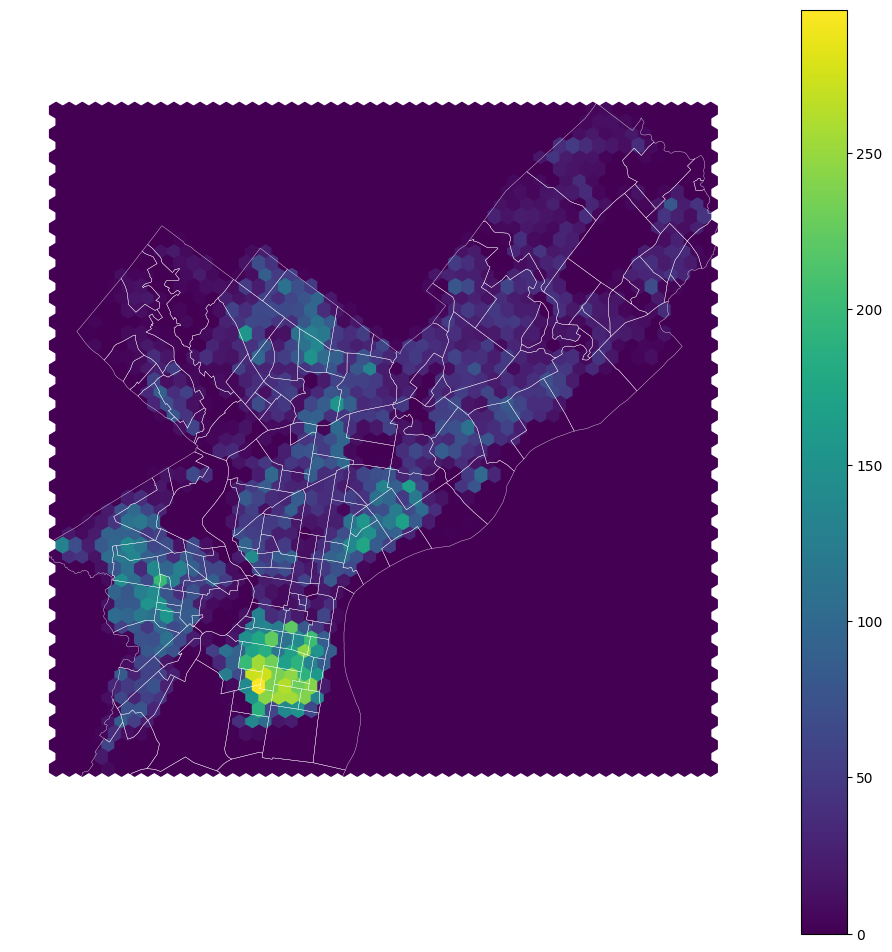

In [64]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Extract out the x/y coordindates of the Point objects
xcoords = trash_requests_3857.geometry.x
ycoords = trash_requests_3857.geometry.y

# Plot a hexbin chart
# NOTE: We are passing the full set of coordinates to matplotlib — we haven't done any aggregations
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)

# Add the zillow geometry boundaries
zillow.to_crs(trash_requests_3857.crs).plot(
    ax=ax, facecolor="none", edgecolor="white", linewidth=0.25
)

# Add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

*Great!* This looks very close to the `N_per_area` choropleth chart we made previously. It definitely shows a similar concentration of tickets in South Philly.

### Interactive via hvplot

Hvplot also has an interactive hex bin function...let's try it out!

**Remember:** once again, we'll be using the original (un-aggregated) data frame.

#### Step 1: Extract out the x/y values of the data 

- Let's add them as new columns into the data frame
- Remember, you can the use "x" and "y" attributes of the "geometry" column.

In [65]:
trash_requests_3857["x"] = trash_requests_3857.geometry.x
trash_requests_3857["y"] = trash_requests_3857.geometry.y

In [66]:
trash_requests_3857.head()

objectid  service_request_id  status  status_notes  \
0   8180042            13269656  Closed           NaN   
1   8180043            13266979  Closed           NaN   
2   7744426            13066443  Closed           NaN   
3   7744427            13066540  Closed           NaN   
4   7801094            13089345  Closed           NaN   

                             service_name service_code  agency_responsible  \
0  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
1  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
2  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
3  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
4  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

    service_notice   requested_datetime     updated_datetime  \
0  2 Business Days  2020-04-02 19:22:24  2020-04-06 07:02:57   
1  2 Business Days  2020-04-02 08:40:53  2020-04-06 07:02:58   
2  2 Business Days  2020-01-02 19:17:55  2020-01-04 05:46:06   
3  2 Business Days  2020-01-03 07:01:46  2020-01-04 05:46:07   
4  2 Business Days  2020-01-15 13:22:14  2020-01-16 14:03:29   

     expected_datetime            address zipcode media_url        lat  \
0  2020-04-06 20:00:00    624 FOULKROD ST     NaN       NaN  40.034389   
1  2020-04-05 20:00:00  1203 ELLSWORTH ST     NaN       NaN  39.936164   
2  2020-01-06 19:00:00   9054 WESLEYAN RD     NaN       NaN  40.058737   
3  2020-01-06 19:00:00    2784 WILLITS RD     NaN       NaN  40.063658   
4  2020-01-16 19:00:00     6137 LOCUST ST     NaN       NaN  39.958186   

         lon                          geometry             x             y  
0 -75.106518  POINT (-8360819.322 4870940.907) -8.360819e+06  4.870941e+06  
1 -75.163497  POINT (-8367162.212 4856670.199) -8.367162e+06  4.856670e+06  
2 -75.018345  POINT (-8351004.015 4874481.442) -8.351004e+06  4.874481e+06  
3 -75.022347  POINT (-8351449.489 4875197.202) -8.351449e+06  4.875197e+06  
4 -75.244732  POINT (-8376205.240 4859867.796) -8.376205e+06  4.859868e+06

#### Step 2: Plot with the hexbin function

- Similar syntax to matplotlib's hexbin() function
- Specify:
    - The x/y coordinates, 
    - An optional `C` column to aggregate for each bin (raw counts are shown if not provided)
    - A `reduce_function` that determines how to aggregate the `C` column

In [67]:
#trash_requests.hvplot.hexbin?

In [68]:
trash_requests.head()

objectid  service_request_id  status  status_notes  \
0   8180042            13269656  Closed           NaN   
1   8180043            13266979  Closed           NaN   
2   7744426            13066443  Closed           NaN   
3   7744427            13066540  Closed           NaN   
4   7801094            13089345  Closed           NaN   

                             service_name service_code  agency_responsible  \
0  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
1  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
2  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
3  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
4  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

    service_notice   requested_datetime     updated_datetime  \
0  2 Business Days  2020-04-02 19:22:24  2020-04-06 07:02:57   
1  2 Business Days  2020-04-02 08:40:53  2020-04-06 07:02:58   
2  2 Business Days  2020-01-02 19:17:55  2020-01-04 05:46:06   
3  2 Business Days  2020-01-03 07:01:46  2020-01-04 05:46:07   
4  2 Business Days  2020-01-15 13:22:14  2020-01-16 14:03:29   

     expected_datetime            address zipcode media_url        lat  \
0  2020-04-06 20:00:00    624 FOULKROD ST     NaN       NaN  40.034389   
1  2020-04-05 20:00:00  1203 ELLSWORTH ST     NaN       NaN  39.936164   
2  2020-01-06 19:00:00   9054 WESLEYAN RD     NaN       NaN  40.058737   
3  2020-01-06 19:00:00    2784 WILLITS RD     NaN       NaN  40.063658   
4  2020-01-16 19:00:00     6137 LOCUST ST     NaN       NaN  39.958186   

         lon                    geometry  
0 -75.106518  POINT (-75.10652 40.03439)  
1 -75.163497  POINT (-75.16350 39.93616)  
2 -75.018345  POINT (-75.01835 40.05874)  
3 -75.022347  POINT (-75.02235 40.06366)  
4 -75.244732  POINT (-75.24473 39.95819)

In [69]:
hexbins = trash_requests_3857.hvplot.hexbin(
    x="x",
    y="y",
    geo=True,
    crs=3857,
    gridsize=40,  # The number of cells in the x/y directions
    alpha=0.5,
    cmap="viridis",
    frame_width=600,
    frame_height=600,
)

# Add the imagery underneath
gvts.EsriImagery * hexbins

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .HexTiles.I :HexTiles   [x,y]

### Which viz method is best?

We've seen a lot of different options for visualizing geospatial data so far. So, which was is best? 

...It depends.

**A few guiding principles:**
- If you're looking to share the visualization with others, static is probably the better choice
- If you're doing an exploratory analysis, generally an interactive map will be more helpful for understanding trends
- For exploratory, interactive analysis, ease of use is key — for this reason, I usually tend to use `.hvplot()` or `.explore()` rather than altair, which doesn't add base tiles to the chart and is a bit more limited in its functionality



## Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using *one or more* of the following:

- Static choropleth map via geopandas
- Interactive choropleth map via geopandas / altair / hvplot
- Static hex bin map via matplotlib
- Interactive hex bin map via hvplot


### The dataset

- Property assessment data from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- Available in the `data/` folder
- Residential properties only — over 460,000 properties 

### Step 1: Load the assessment data

In [70]:
data = pd.read_csv("./data/opa_residential.csv")
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

We'll focus on the `market_value` column for this analysis

### Step 2: Convert to a GeoDataFrame

Remember to set the EPSG of the input data — this data is in the typical lat/lng coordinates (EPSG=4326)

In [71]:
data = data.dropna(subset=["lat", "lng"])

In [72]:
gdata = gpd.GeoDataFrame(
    data,  # The pandas DataFrame
    geometry=gpd.points_from_xy(data["lng"], data["lat"]), # The geometry!
    crs="EPSG:4326", # The CRS 
)

In [73]:
gdata.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  \
0         44473.0     17727.0          1109.69              1638.0   
1         18018.0      7182.0          1109.69              1638.0   
2         44473.0     17727.0          1109.69              1638.0   
3         11083.0      4417.0          1109.69              1638.0   
4         22400.0      8900.0           643.50               890.0   

                     geometry  
0  POINT (-75.12899 39.99158)  
1  POINT (-75.12898 39.99170)  
2  POINT (-75.12897 39.99174)  
3  POINT (-75.12889 39.99199)  
4  POINT (-75.12874 39.99259)

In [74]:
len(gdata)

461453

### Step 3: Do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

Make sure you CRS's match before doing the sjoin!

In [75]:
zillow.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [76]:
gdata = gdata.to_crs(zillow.crs)

In [77]:
gdata = gpd.sjoin(gdata, zillow, predicate="within", how="left")

In [78]:
gdata.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  \
0         44473.0     17727.0          1109.69              1638.0   
1         18018.0      7182.0          1109.69              1638.0   
2         44473.0     17727.0          1109.69              1638.0   
3         11083.0      4417.0          1109.69              1638.0   
4         22400.0      8900.0           643.50               890.0   

                     geometry  index_right ZillowName  
0  POINT (-75.12899 39.99158)         79.0    McGuire  
1  POINT (-75.12898 39.99170)         79.0    McGuire  
2  POINT (-75.12897 39.99174)         79.0    McGuire  
3  POINT (-75.12889 39.99199)         79.0    McGuire  
4  POINT (-75.12874 39.99259)         79.0    McGuire

### Step 4: Make a choropleth of the median market value by neighborhood

Use the built-in `.plot()` function to make a static version, or `.explore()` to make an interactive version. 

::: {.callout-tip title="Hints"}
- You will need to group by Zillow neighborhood
- Calculate the median market value per neighborhood
- Join with the Zillow neighborhood GeoDataFrame
:::

In [79]:
median_values = gdata.groupby("ZillowName", as_index=False)["market_value"].median()

In [80]:
median_values.head()

ZillowName  market_value
0   Academy Gardens      185950.0
1    Allegheny West       34750.0
2           Andorra      251900.0
3  Aston Woodbridge      183800.0
4   Bartram Village       48300.0

In [81]:
# Merge in the median values ---> geopandas .merge pandas
median_values_by_hood = zillow.merge(median_values, on="ZillowName")

# Normalize
median_values_by_hood["market_value"] /= 1e3  # in thousands

In [82]:
median_values_by_hood.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-74.99851 40.06435, -74.99456 40.061...   
1    Allegheny West  POLYGON ((-75.16592 40.00327, -75.16596 40.003...   
2           Andorra  POLYGON ((-75.22463 40.06686, -75.22588 40.065...   
3  Aston Woodbridge  POLYGON ((-75.00860 40.05369, -75.00861 40.053...   
4   Bartram Village  POLYGON ((-75.20733 39.93350, -75.20733 39.933...   

   market_value  
0        185.95  
1         34.75  
2        251.90  
3        183.80  
4         48.30

#### Static

/var/folders/lv/8xb4hscx2hs0c0fwhd2bnjy80000gn/T/ipykernel_2736/267722563.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels([f"${val:.0f}k" for val in cax.get_yticks()]);


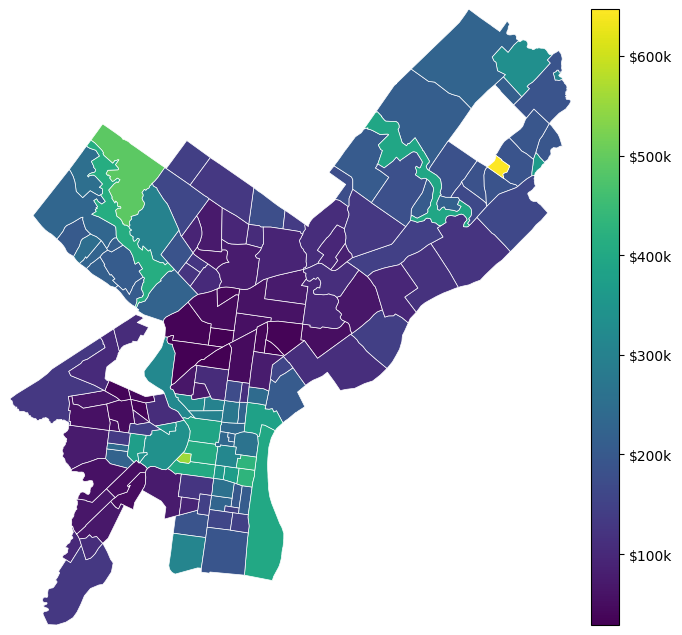

In [83]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
# NOTE: I am using PA state plane (2272) as an example
median_values_by_hood_2272 = median_values_by_hood.to_crs(epsg=2272)
median_values_by_hood_2272.plot(
    ax=ax, cax=cax, column="market_value", edgecolor="white", linewidth=0.5, legend=True
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = median_values_by_hood_2272.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

# Format cax labels
cax.set_yticklabels([f"${val:.0f}k" for val in cax.get_yticks()]);

#### Interactive

In [84]:
# Via geopandas
median_values_by_hood.explore(column="market_value")

In [85]:
# Via hvplot

choro = median_values_by_hood.to_crs(epsg=3857).hvplot(
    c="market_value",
    frame_width=600,
    frame_height=600,
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

gvts.EsriImagery * choro

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (market_value,ZillowName)

In [86]:
# Via altair
# NOTE: I've projected to my desired CRS and then passed in the data

(
    alt.Chart(median_values_by_hood.to_crs(epsg=2272))
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["market_value:Q", "ZillowName:N"],
        color=alt.Color("market_value:Q", scale=alt.Scale(scheme="viridis")),
    )
    # Important! Otherwise altair will try to re-project your data
    .project(type="identity", reflectY=True)
    .properties(width=500, height=500)
)

alt.Chart(...)

### Step 5: Make a hex bin map of median assessments

Make a static version with matplotlib or an interactive version with hvplot.

**Remember,** you will need to pass in the original, un-aggregated data to the plotting function!

::: {.callout-tip title="Hints"}

For matplotlib's `hexbin()` function:
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

For hvplot's `hexbin()` function:
- You will need to use the `C` and `reduce_function` of the `hexbin()` function
- Run `df.hvplot.hexbin?` for more help
- Try testing the impact of setting `logz=True` on the resulting map


:::

**Note:** you should pass in the raw point data rather than any aggregated data to the `hexbin()` function

#### Static

In [87]:
# Convert to a projected CRS with units of meters
gdata_3857 = gdata.to_crs(epsg=3857)

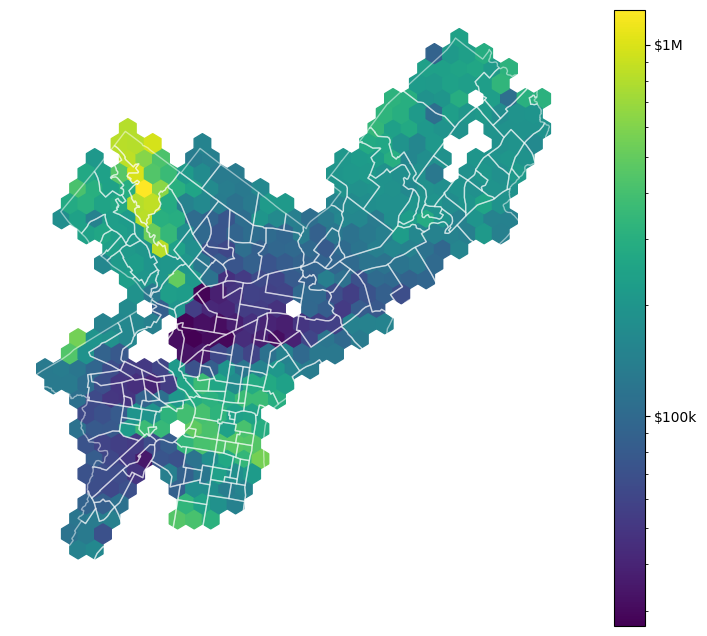

In [88]:
# Create the axes
fig, ax = plt.subplots(figsize=(10, 8))


# Use the .x and .y attributes to get coordinates
xcoords = gdata_3857.geometry.x
ycoords = gdata_3857.geometry.y

# NOTE: we are passing in the raw point values here!
# Matplotlib is doing the binning and aggregation work for us!
hex_vals = ax.hexbin(
    xcoords,
    ycoords,
    C=gdata_3857.market_value / 1e3,  # Values to aggregate!
    reduce_C_function=np.median,  # Use the median function to do the aggregation in each bin
    bins="log",  # Use log scale for color
    gridsize=30,
)

# Add the zillow geometry boundaries
# NOTE: I'm making sure it's in the same CRS as gdata_3857
zillow.to_crs(gdata_3857.crs).plot(
    ax=ax, facecolor="none", edgecolor="white", linewidth=1, alpha=0.5
)

# Add a colorbar and format
cbar = fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

# Format cbar labels
cbar.set_ticks([100, 1000])
cbar.set_ticklabels(["$100k", "$1M"]);

#### Interactive

In [89]:
# Add them as columns
gdata_3857["x"] = gdata_3857.geometry.x
gdata_3857["y"] = gdata_3857.geometry.y

*Note:* this might take a minute or two!

In [90]:
hexbins = gdata_3857.hvplot.hexbin(
    x="x",
    y="y",
    geo=True,
    crs=3857,
    gridsize=40,
    reduce_function=np.median,  # NEW: the function to use to aggregate in each bin
    C="market_value",  # NEW: the column to aggregate in each bin
    logz=True,  # Use a log color map
    alpha=0.5,
    cmap="viridis",
    frame_width=600,
    frame_height=600,
)

# Add the imagery underneath
gvts.EsriImagery * hexbins

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .HexTiles.I :HexTiles   [x,y]   (market_value)

In [128]:
import geopandas as gpd
import pandas as pd

# Interactive maps in Python

Haven't we already done this?

**Yes!** So far, we've used hvplot, geopandas, & altair to create interactive map-based visualizations.

## Why do we need something more?

<img src="imgs/leaflet-logo.png" width=500></img>

[Leaflet documentation](https://leafletjs.com/)

## The benefits of Leaflet

- The leading open-source mapping library
- Simple and powerful
- Leverage the open-source community and lots of powerful plugins

## Folium: Leaflet in Python

**Pros**
- Create Leaflet.js maps directly from Python
- Combine power of Leaflet.js with the data wrangling ease of Python

**Cons**
- A wrapper for **most, but not all** of Leaflet's functionality
- Can be difficult to debug and find errors


--> Check out the [Folium docs](https://python-visualization.github.io/folium/latest/index.html) for more info.


## We've already seen choropleth maps with Folium

The geopandas `.explore()` function, which makes interactive choropleth maps, produces Folium maps!

Let's load the median property assessment data by neighborhood from last lecture's exercise:

In [129]:
# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "data/trash_311_requests_2020.csv",  # Use the file path relative to the current folder
)

# Remove rows with missing geometry
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])


# Create our GeoDataFrame with geometry column created from lon/lat
trash_requests = gpd.GeoDataFrame(
    trash_requests_df,
    geometry=gpd.points_from_xy(trash_requests_df["lon"], trash_requests_df["lat"]),
    crs="EPSG:4326",
)

Load neighborhoods and do the spatial join to associate a neighborhood with each ticket:

In [130]:
# Load the neighborhoods
neighborhoods = gpd.read_file("data/zillow_neighborhoods.geojson")

# Do the spatial join to add the "ZillowName" column
requests_with_hood = gpd.sjoin(
    trash_requests,
    neighborhoods.to_crs(trash_requests.crs),
    predicate="within",
)

Group by neighborhood, calculate the number of tickets per neighborhood, and then merge neighborhood geometries.

In [131]:
requests_by_hood = pd.merge(
    # GeoDataFrame is left
    neighborhoods,
    # DataFrame is right: This is the number of tickets per neighborhood
    requests_with_hood.groupby("ZillowName", as_index=False).size(),
    # Merge column,
    on="ZillowName",
).rename(
    # Rename size column
    columns={"size": "num_tickets"}
)

# Get the area of each geometry in sq. meters
# NOTE: we are converting to EPSG:3857 which has units of meters
area = requests_by_hood.to_crs(epsg=3857).geometry.area


# Normalize by area
requests_by_hood["num_tickets_per_area"] = requests_by_hood["num_tickets"] / area * 1e4

In [132]:
requests_by_hood.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-74.99851 40.06435, -74.99456 40.061...   
1    Allegheny West  POLYGON ((-75.16592 40.00327, -75.16596 40.003...   
2           Andorra  POLYGON ((-75.22463 40.06686, -75.22588 40.065...   
3  Aston Woodbridge  POLYGON ((-75.00860 40.05369, -75.00861 40.053...   
4   Bartram Village  POLYGON ((-75.20733 39.93350, -75.20733 39.933...   

   num_tickets  num_tickets_per_area  
0           84              0.350561  
1          330              0.646749  
2           83              0.212905  
3          110              0.486609  
4           35              0.155914

The `.explore()` function is a wrapper around Folium/leaflet.js

In [133]:
m = requests_by_hood.explore(column="num_tickets_per_area", tiles="Cartodb positron")

m

The object returned by `.explore()` a Folium map!

In [134]:
type(m)

folium.folium.Map

### The explore() function

The `.explore()` function is a powerful wrapper around folium with a lot of the same functionality of the `plot()` function in geopandas. In my experience, it is much easier to work with than folium directly. My recommendation is to use the `.explore()` function when you can.

#### Classification schemes

You can use the same classification schemes to bin your data when using the `explore()` function. For example:

In [135]:
m = requests_by_hood.explore(
    column="num_tickets_per_area",
    tiles="Cartodb positron",
    scheme="FisherJenks",  # NEW: the classification scheme
    k=5,  # NEW: the number of bins
)

m

/Users/delmelle/miniforge3/lib/python3.10/site-packages/geopandas/explore.py:464: UserWarning: Numba not installed. Using slow pure python version.
  binning = classify(


#### Style options

The `explore()` function allows you to specify dictionaries with style keywords for the GeoJSON. The allowed options come directly from the leaflet.js library. Check out the documentation for the `.explore()` function for more info. You can see the allowed values for GeoJSON on the [leaflet documentation](https://leafletjs.com/reference.html#path-option).

For example, let's plot our neighborhood GeoJSON and apply a default style, as well as as a style for when the user hover (highlights) a polygon.

In [137]:
m = requests_by_hood.explore(
    tiles="Cartodb dark matter",
    # NEW: The style dictionary
    style_kwds={
        "weight": 2,
        "color": "lightblue",
        "fillOpacity": 0.1,
    },
    highlight=True,  # NEW: turn on highlighting
    # NEW: The style dict to apply when hovering
    highlight_kwds={
        "weight": 2,
        "color": "red",
    },
)

m

You can also perform styling via functions that take in a GeoJSON feature and return a dictionary of style options. This allows you to style GeoJSON features differently based on the `.properties` attribute of the GeoJSON feature.

For example:


In [99]:
def my_style_function(feature):
    """Change the style based on whether the number of tickets > 500."""

    # Data attributes stored in properties dict
    properties = feature["properties"]

    # Shared style
    style = {"weight": 2, "fillOpacity": 0.8, "color": "white"}

    # Change fillColor
    if properties["num_tickets"] > 500:
        style["fillColor"] = "red"
    else:
        style["fillColor"] = "lightblue"

    # Return style dict
    return style

In [138]:
m = requests_by_hood.explore(
    tiles="Cartodb dark matter",
    style_kwds={"style_function": my_style_function},  # NEW: The style function
)

m

## More Folium features

We'll cover a few more of the key features of Folium today...

**Things we'll cover:**
1. Creating a base map with tiles
1. Overlaying GeoJSON features with layer control
1. Examples of Folium plugins

In [139]:
import folium

### 1. Creating a Folium map

**Key function:** `folium.Map`

#### Lots of configuration options

Some key ones: 
- **location**: the center location of the map
- **zoom_start**: the initial zoom level of the map
- **tiles**: the name of the tile provider 

Let's take a look at the help message:

In [140]:
#folium.Map?

#### The default tiles: OpenStreetMap

In [141]:
# let's center the map on Philadelphia
m = folium.Map(location=[39.99, -75.13], zoom_start=11)

m

#### Other tile providers

Check out the `xyzservices.providers` for all of the available options. You can pass any of these built-in tile providers to `Folium.Map()` or the `.explore()` function.

::: {.callout-tip}
Here is a very useful demo of common tile providers: https://leaflet-extras.github.io/leaflet-providers/preview
:::

In [105]:
import xyzservices

In [106]:
#xyzservices.providers

Let's try out a couple of examples:

USGS Topo:

In [145]:
m = folium.Map(
    location=[39.99, -75.13], zoom_start=11, tiles=xyzservices.providers.USGS.USTopo
)

m

Esri National Geographic World Map:

In [146]:
m = folium.Map(
    location=[39.99, -75.13],
    zoom_start=11,
    tiles=xyzservices.providers.Esri.NatGeoWorldMap,
)

m

CartoDB Dark Matter:

In [109]:
m = folium.Map(
    location=[39.99, -75.13],
    zoom_start=11,
    tiles=xyzservices.providers.CartoDB.DarkMatter,
)

m

### 2. Overlaying multiple GeoJSON layers on a folium map

The `.explore()` function can handle points in addition to polygon geometry objects. And you can layer multiple types of GeoJSON on the same folium map, and add a widget to control which layers are active on the map.


As an example, we'll keep exploring our trash-related 311 ticket dataset. Let's take a look at the top 10 neighborhoods in terms of the number of tickets per neighborhood area:

In [147]:
requests_by_hood.sort_values(by="num_tickets_per_area", ascending=False).head(n=10)

ZillowName                                           geometry  \
57           Greenwich  POLYGON ((-75.15294 39.92465, -75.15342 39.922...   
31       East Passyunk  POLYGON ((-75.16971 39.92442, -75.16835 39.930...   
86             Newbold  POLYGON ((-75.16971 39.92442, -75.17023 39.921...   
72   Lower Moyamensing  POLYGON ((-75.15660 39.92271, -75.15827 39.915...   
5          Bella Vista  POLYGON ((-75.15865 39.94277, -75.15757 39.942...   
25              Dunlap  POLYGON ((-75.22457 39.96492, -75.21995 39.963...   
139      West Passyunk  POLYGON ((-75.18528 39.93020, -75.17533 39.928...   
108       Point Breeze  POLYGON ((-75.18495 39.94013, -75.17622 39.939...   
103          Pennsport  POLYGON ((-75.14531 39.93361, -75.14532 39.933...   
142            Whitman  POLYGON ((-75.14766 39.91674, -75.14825 39.913...   

     num_tickets  num_tickets_per_area  
57           214              6.781077  
31           648              6.222775  
86           525              5.712863  
72           881              5.366825  
5            416              5.082199  
25           189              4.983522  
139          495              4.888462  
108         1154              4.308334  
103          447              4.062493  
142          476              3.983558

The Greenwich neighborhood has the highest number of tickets per area, but a relatively low number of overall tickets. Let's take a look at the tickets in closer detail.

In [150]:
# Extract out the point tickets for Greenwich
greenwich_tickets = requests_with_hood.query("ZillowName == 'Greenwich'")

In [151]:
# Get the neighborhood boundary for Greenwich
greenwich_geo = neighborhoods.query("ZillowName == 'Greenwich'")

::: {.callout-note}

If you are using the `.explore()` function in geopandas, you if you have an existing Folium map, you can pass it to the `explore()` function using the `m=` keyword. See the [docs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) for more info.

:::

In [152]:
# Plot the neighborhood boundary
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)


# Add the individual tickets as circle markers and style them
greenwich_tickets.explore(
    m=m,  # Add to the existing map!
    marker_kwds={"radius": 7, "fill": True, "color": "crimson"},
    marker_type="circle_marker", # or 'marker' or 'circle'
    name="Tickets",
)

# Hse folium to add layer control
folium.LayerControl().add_to(m)

m  # show map

Interesting! There are definitely *spatial* clusters of 311 tickets, e.g., hot spots. But these tickets are from *all* of 2020...

**Question:** I wonder if they were clustered in *time* as well as space, e.g., a large number of tickets in a short period of time. This could be indicative of a couple bad weeks of trash collections, and a few "power users" putting in lots of repeat 311 tickets to the City if the issue was resolved. 

Let's use the folium/leaflet plugin ecosystem to try to answer this question!

### 3. Leaflet/Folium plugins

One of leaflet's strengths: a rich set of open-source plugins

https://leafletjs.com/plugins.html

Many of these are available in Folium! Check out the [plugins gallery](https://python-visualization.github.io/folium/latest/user_guide/plugins.html) on the folium documentation for examples.

#### 3A. Time-stamped GeoJSON

The `folium.plugins.TimestampedGeoJson()` object can plot a GeoJSON collection over time, adding a slider to control what time frame is currently shown.

Let's use this to examine the trends in tickets in Greenwich by month in 2020...


::: {.callout-note title="Notes"}

There's a few things we'll need to do to prepare:

- Add a "time" column that includes the datetime for each point. We can rename our "requested_datetime" column. 
- Pass in GeoJSON to the function, not the GeoDataFrame. We can use the `.to_json()` function to convert.
- Choose a time period to show on the slider, e.g., how many time slices to show. We will use a monthly interval below.

:::

In [155]:
# Select only the two columns we need and rename to "time"
ticket_timestamps = (
    greenwich_tickets[["requested_datetime", "geometry"]]
    .rename(columns={"requested_datetime": "time"})
)

In [156]:
# Plot the neighborhood boundary first
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)

# Add the time-stamped GeoJSON
folium.plugins.TimestampedGeoJson(
    ticket_timestamps.to_json(),  # Convert to GeoJSON
    period="P1M",  # Show the data in one month intervals
    duration="P1M",  # Only show points for 1 month and then remove them
    auto_play=False,  # Don't start playing by default
    loop=False,  # Loop the animation
    max_speed=1,  # Max frame speed
    loop_button=True,  # Show a loop button
    transition_time=500,  # Time between frames in ms
).add_to(m)

m

AttributeError: module 'folium' has no attribute 'plugins'

Ah! The summer months, July and August in particular, saw a lot of requests, just as we saw before with the citywide data! By September or October the number of tickets declines, showing that the trash-related problems were a short-term issue.

::: {.callout-note title="Deep dive: Styling the markers"}

*A brief deep dive, feel free to keep moving!* 

Styling the markers in this case is much harder to do than when we were working with the `.explore()` function. We need to add the style dictionary we want as a attribute of each feature's property dictionary. So we'll need to convert to a GeoJSON dict, and then manually loop over each feature and add the style we want.

The example below really illustrates how `.explore()` is often the best option for its ease of use!

:::

The `.to_json()` function returns a string version of the GeoJSON dict. We can parse it into a Python dict by using the `json.loads()` function.

In [116]:
import json

In [117]:
# This is our GeoJSON points as a dict
geosjon_dict = json.loads(ticket_timestamps.to_json())

In [127]:
#geosjon_dict

Now loop over each feature and add the style:

In [119]:
for feature in geosjon_dict["features"]:
    
    # Use a circle for each icon
    feature["properties"]["icon"] = "circle"
    
    # Style the circles
    feature["properties"]["style"] = {"radius": 10, "fill": True, "color": "crimson"}

In [120]:
# Plot the neighborhood boundary first
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)

# Add the time-stamped GeoJSON
folium.plugins.TimestampedGeoJson(
    geosjon_dict,  # NEW: use the styled GeoJSON
    period="P1M",
    duration="P1M",
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    transition_time=500,
).add_to(m)

m

AttributeError: module 'folium' has no attribute 'plugins'

#### 3B. Heatmaps


In [121]:
folium.plugins.HeatMap?

Object `folium.plugins.HeatMap` not found.


In [122]:
coords = greenwich_tickets[['lat', 'lon']]

In [123]:
# Plot the neighborhood boundary first
m = greenwich_geo.explore(
    style_kwds={"weight": 4, "color": "black", "fillColor": "none"},
    name="Neighborhood boundary",
    tiles=xyzservices.providers.CartoDB.Voyager,
)

# Add heat map coordinates
folium.plugins.HeatMap(coords.values, radius=20).add_to(m)

# Show map
m

AttributeError: module 'folium' has no attribute 'plugins'

#### 3C: Marker clusters

**Question:** Can we visualize all tickets citywide in 2020 at once? 

In [124]:
len(trash_requests)

47690

Let's try the heat map plugin:

In [125]:
# let's center the map on Philadelphia
m = folium.Map(
    location=[39.99, -75.13], zoom_start=11, tiles=xyzservices.providers.CartoDB.Voyager
)

# All coords
coords = trash_requests[["lat", "lon"]] # Remember, (lat, lon) order

# Add heat map coordinates
folium.plugins.HeatMap(coords.values, radius=20).add_to(m)

# Show map
m

AttributeError: module 'folium' has no attribute 'plugins'

...Not great! There are too many points to properly visualize all of the data at once.

Instead, let's check out `folium.plugins.FastMarkerCluster()`. This plugin clusters the data automatically for each zoom level, and can easily handle thousands of points at once without crashing your browser. 



In [126]:
# let's center the map on Philadelphia
m = folium.Map(
    location=[39.99, -75.13], zoom_start=11, tiles=xyzservices.providers.CartoDB.DarkMatter
)


folium.plugins.FastMarkerCluster(data=coords).add_to(m)

m

AttributeError: module 'folium' has no attribute 'plugins'

::: {.callout-note title='Reminder'}

Check out the [plugins gallery](https://python-visualization.github.io/folium/latest/user_guide/plugins.html) on the folium documentation for the available plugins and examples for each.

:::

## That's it!

- See you next time for more geospatial analysis
- We'll dive into urban street networks and raster data